#### Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from scipy.fft import fft, fftfreq
from sklearn import preprocessing
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Functions

In [2]:
def get_capacitive_values(data_path):
    #Samples before and after init
    N = 800
    # Opening JSON file
    f = open(data_path)
    # returns JSON object as a dictionary
    dict_json = json.load(f)
    df = pd.DataFrame(dict_json)
    #df = df[500:1000]
    # Closing file
    f.close()
    
    #Get data from right channel:
    face_right_channel_eyebrows = df["cap_1_0"].to_list()
    face_right_channel_mouth= df["cap_1_1"].to_list()
    face_right_channel_nose= df["cap_1_2"].to_list()
    face_right_channel_cheekbones= df["cap_1_3"].to_list()
    
    #Substract the mean value for each channel.
    #Right channels:
    face_right_channel_eyebrows = (face_right_channel_eyebrows - np.mean(face_right_channel_eyebrows)).tolist()
    face_right_channel_cheekbones = (face_right_channel_cheekbones - np.mean(face_right_channel_cheekbones)).tolist()
    face_right_channel_nose = (face_right_channel_nose - np.mean(face_right_channel_nose)).tolist()
    face_right_channel_mouth = (face_right_channel_mouth - np.mean(face_right_channel_mouth)).tolist()

    #PLOT Right Face Sections - Without OFFSET
    plt.figure(figsize=(15, 5))
    plt.plot(face_right_channel_eyebrows)
    plt.plot(face_right_channel_cheekbones)
    plt.plot(face_right_channel_nose)
    plt.plot(face_right_channel_mouth)
    plt.title('Right Face Sections - Without OFFSET')
    plt.xlabel('Samples')
    plt.ylabel('DataX')
    plt.grid()
    plt.show()
      
    T=2
    plt.title('Left Face Sections - FFT')
    yf = fft(face_right_channel_eyebrows)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_cheekbones)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_nose)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_right_channel_mouth)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

    ###################################################################################################################
    
    #Get data from left channel:
    face_left_channel_eyebrows = df["cap_0_0"].to_list()
    face_left_channel_mouth= df["cap_0_1"].to_list()
    face_left_channel_nose= df["cap_0_2"].to_list()
    face_left_channel_cheekbones= df["cap_0_3"].to_list()
    
    #Left channels:
    face_left_channel_eyebrows = (face_left_channel_eyebrows - np.mean(face_left_channel_eyebrows)).tolist()
    face_left_channel_cheekbones = (face_left_channel_cheekbones - np.mean(face_left_channel_cheekbones)).tolist()
    face_left_channel_nose = (face_left_channel_nose - np.mean(face_left_channel_nose)).tolist()
    face_left_channel_mouth = (face_left_channel_mouth - np.mean(face_left_channel_mouth)).tolist()
    
    #PLOT Left Face Sections - Without OFFSET
    plt.figure(figsize=(15, 5))
    plt.plot(face_left_channel_eyebrows)
    plt.plot(face_left_channel_cheekbones)
    plt.plot(face_left_channel_nose)
    plt.plot(face_left_channel_mouth)
    plt.title('Left Face Sections - Without OFFSET')
    plt.xlabel('Samples')
    plt.ylabel('DataX')
    plt.grid()
    plt.show()
    
    plt.title('Left Face Sections - FFT')
    yf = fft(face_left_channel_eyebrows)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_cheekbones)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_nose)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    yf = fft(face_left_channel_mouth)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()

    face_dict = {
        "Right-Eyebrows": face_right_channel_eyebrows,
        "Left-Eyebrows": face_left_channel_eyebrows,
        "Right-Cheekbones": face_right_channel_cheekbones,
        "Left-Cheekbones": face_left_channel_cheekbones,
        "Right-Nose": face_right_channel_nose,
        "Left-Nose": face_left_channel_nose,
        "Right-Mouth": face_right_channel_mouth,
        "Left-Mouth": face_left_channel_mouth
      }
  
    df = pd.DataFrame(face_dict)

    return df

In [3]:
# Generate multivariate features with window_size from parallel secuences.
def generate_input_time_slices(dataframe, window_cap_size, n_feature_values):
    x = []
    for i in range(len(dataframe.index)):
        end_step = i + window_cap_size
        out_end_ix = end_step + window_cap_size
        if out_end_ix > len(dataframe.index):
            break
        # Separate time feature values from time target values.
        x.append(dataframe.iloc[i:end_step, 0:n_feature_values].values)
        
    return np.array(x)

In [4]:
def normalize_capacitance_values(dataset_cap):

  min_max_scaler = preprocessing.MinMaxScaler()
  scaled_dataset = min_max_scaler.fit_transform(dataset_cap)
  scaled_dataset = pd.DataFrame(scaled_dataset)

  return scaled_dataset

In [5]:
# Consider data capacitive data after hand touch on left mouth antena + 30 (3 secs = sync_thr because freq of cap acquisition is 10Hz).
def sync_cap(dataset_cap, frame_init_hand, frame_end_hand):
  
  dataset_cap = dataset_cap[frame_init_hand:frame_end_hand-1]

  return dataset_cap

## Capacitive Data Processing for Regressor:

In [6]:
#Samples before and after init
f = open("/content/drive/MyDrive/Regressor/Recording_JSON/Recordings_Train.json")
# returns JSON object as a dictionary
dict_json = json.load(f)
sync_pd = pd.DataFrame(dict_json)
# Closing file
f.close()

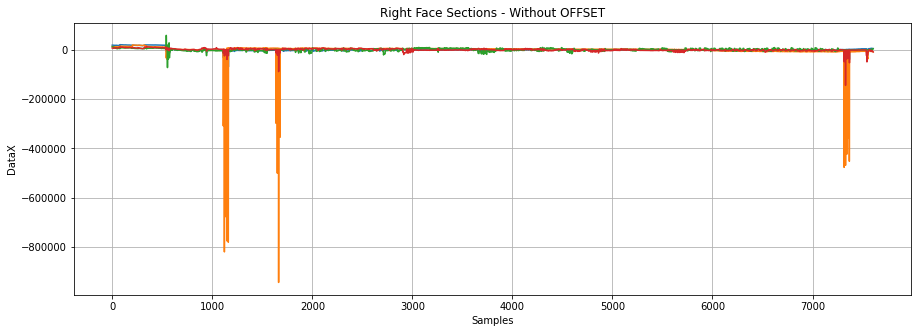

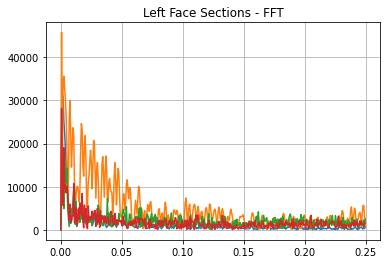

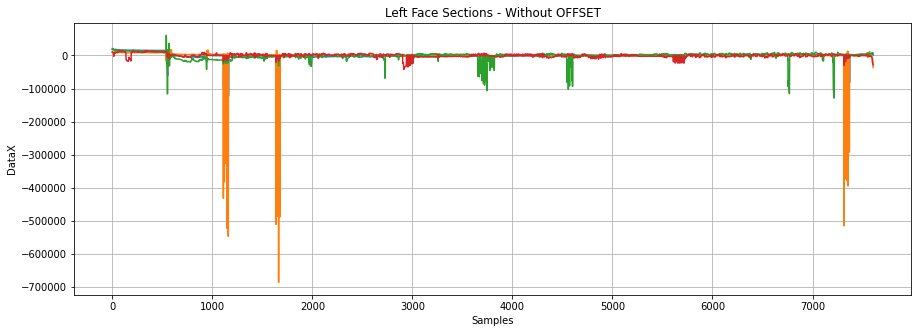

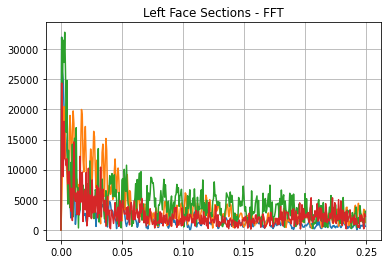

Number of Cap samples in File #1:  7607
Point Start Synchronization - Capacitive #1: 1677
Point End Synchronization - Capacitive #1: 7369
Number of Samples in File #1 - Recording:David_R1 - Capacitive Data after Sync:  5691


In [20]:
#Samples before and after init
f = open("/content/drive/MyDrive/Regressor/Recording_JSON/Recordings_Train.json")
# returns JSON object as a dictionary
dict_json = json.load(f)
sync_pd = pd.DataFrame(dict_json)
# Closing file
f.close()

##### TRAIN #####
n_samples = 1
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "/content/drive/MyDrive/Regressor/Capacitive_Data_Train/Capacitive_Train_Record(" + file_number + ").json"
    # Read Excel file.
    dataset_cap = get_capacitive_values(file_name_cap)

    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
      
    #Synchronization between Capacitive and FaceLandmarks data.
    print("Point Start Synchronization - Capacitive #" + str(file_number) + ":", sync_pd.Cap_Init_Touch[i])
    print("Point End Synchronization - Capacitive #" + str(file_number) + ":", sync_pd.Cap_End_Touch[i])
    sync_dataset_cap = sync_cap(dataset_cap, sync_pd.Cap_Init_Touch[i], sync_pd.Cap_End_Touch[i])
    print("Number of Samples in File #" + str(file_number) + " - Recording:" + str(sync_pd.Record_Name[i]) + " - Capacitive Data after Sync: " , len(sync_dataset_cap))

    #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(sync_dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(norm_dataset_cap, window_cap_size, n_feature_values)
      
    np.save("/content/drive/MyDrive/Regressor/Capacitive_Data_Train/Capacitive_Train_Process("+ file_number +").npy", features)

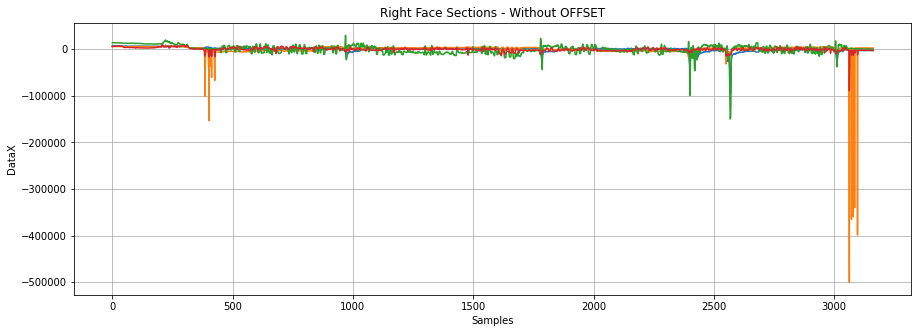

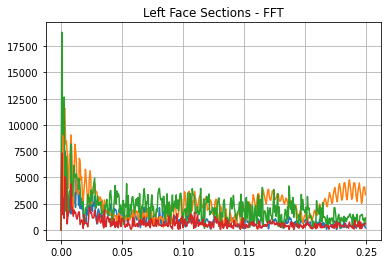

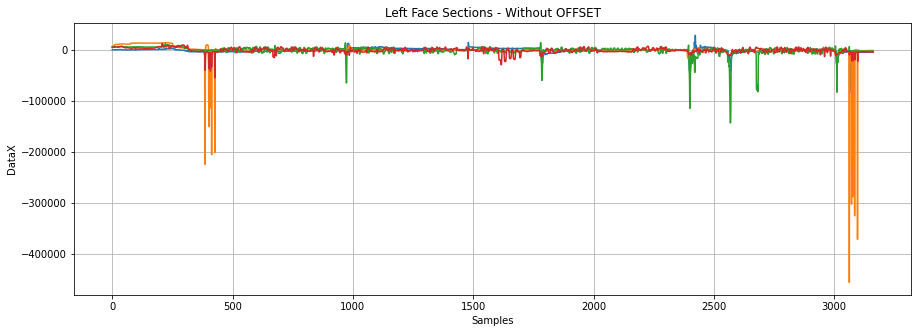

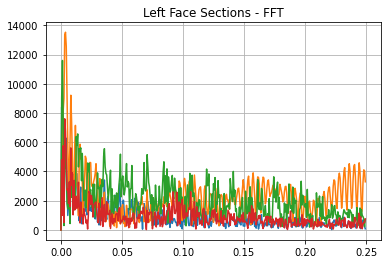

Number of Cap samples in File #1:  3163
Point Start Synchronization - Capacitive #1: 1677
Point End Synchronization - Capacitive #1: 7369
Number of Samples in File #1 - Recording:David_R1 - Capacitive Data after Sync:  1486


In [21]:
#Samples before and after init
f = open("/content/drive/MyDrive/Regressor/Recording_JSON/Recordings_Test.json")
# returns JSON object as a dictionary
dict_json = json.load(f)
sync_pd = pd.DataFrame(dict_json)
# Closing file
f.close()

##### TEST #####
n_samples = 1
downsample = 3
window_cap_size = 20 #(2 secs)
n_feature_values = 8
features_cap_timeslice = []

for i in range(n_samples):
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "/content/drive/MyDrive/Regressor/Capacitive_Data_Test/Capacitive_Test_Record(" + file_number + ").json"
    # Read Excel file.
    dataset_cap = get_capacitive_values(file_name_cap)

    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
      
    #Synchronization between Capacitive and FaceLandmarks data.
    print("Point Start Synchronization - Capacitive #" + str(file_number) + ":", sync_pd.Cap_Init_Touch[i])
    print("Point End Synchronization - Capacitive #" + str(file_number) + ":", sync_pd.Cap_End_Touch[i])
    sync_dataset_cap = sync_cap(dataset_cap, sync_pd.Cap_Init_Touch[i], sync_pd.Cap_End_Touch[i])
    print("Number of Samples in File #" + str(file_number) + " - Recording:" + str(sync_pd.Record_Name[i]) + " - Capacitive Data after Sync: " , len(sync_dataset_cap))

    #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(sync_dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(norm_dataset_cap, window_cap_size, n_feature_values)
      
    np.save("/content/drive/MyDrive/Regressor/Capacitive_Data_Test/Capacitive_Test_Process("+ file_number +").npy", features)